In [ ]:
# hide
# all_tutorial

# Tutorial - Structure Enumeration

> Overview of how to use the `StructureEnumerator` class

## Overview

Structure enumeration is a useful way to explore constrained chemical spaces. You might want to try swapping a ring in a molecule with every possible 6 member ring, or try every linker with four atoms or less.

The `StructureEnumerator` class provides a principled way of enumerating constrained chemical spaces. The jist of it is this. We create a SMARTs template outlining the general structure we want to enumerate. Then, for every atom and bond we want to vary, we define a list of allowed substitutions. The `StructureEnumerator` then generates all combinations based on these specifications and filters them for chemical validity.

In [ ]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from rdkit import Chem

//anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Basic Example

Lets say we want to generate all variants of a 5 or 6 membered ring with 3 attachment points and at most 3 heteroatoms.

First we start with the base smiles string for a 6-membered ring. 

`C1CCCCC1`

We convert this to a smarts string

`'[#6]1-[#6]-[#6]-[#6]-[#6]-[#6]-1'`

The `StructureEnumerator` relies on atom mapping to avoid worrying about atom order. We add a mapping number to every atom in the smarts

`'[#6:1]1-[#6:2]-[#6:3]-[#6:4]-[#6:5]-1'`

This process can be automated with the `add_map_nums` function:

In [ ]:
mol = to_mol('C1CCCCC1')    
smart = to_smart(add_map_nums(mol))
smart

'[#6:1]1-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#6:6]-1'

Now we define the specifications for enumerating atoms and bonds.

Atom specifications are defined in a dictionary of the form `map_num : [possible_atoms]`. So `atom_spec = {2 : ['C', 'N', 'O']}` would denote enumerating carbon, nitrogen and oxygen at the atom defined by map number 1.

Bond specifications are defined in a dictionary of the form `(start_map_num, end_map_num) : [possible_bond_types]`. So `bond_spec = {(1,2) : ['single', 'double']}`  would denote enumerating single and double bonds at the bond between the atom with map number 1 and the atom with map number 2. The code checks both `(start_map_num, end_map_num)` and `(end_map_num, start_map_num)` so the index order doesn't matter.

Any atoms or bonds not included in `atom_spec` or `bond_spec` are left as-is based on the smarts definition. Note that the end state for generated compounds is SMILES strings, so atoms or bonds left unchanged should be SMILES compatible.

To make things easy, the `generate_spec_template` function creates a bank `atom_spec` and `bond_spec` from a given `mol`, along with the matching mapped smarts string.

In [ ]:
atom_spec, bond_spec, smarts = generate_spec_template(mol)
print(atom_spec)
print(bond_spec)
print(smarts)

{1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
{(1, 2): [], (2, 3): [], (3, 4): [], (4, 5): [], (5, 6): [], (6, 1): []}
[#6:1]1-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#6:6]-1


For this task, we want to enumerate `['C', 'N', 'O']` at all atom positions and `['aromatic','single','double']` at all bond positions. That gives us the following:

In [ ]:
for key in atom_spec.keys():
    atom_spec[key] = ['C','N','O']
    
for key in bond_spec.keys():
    bond_spec[key] = ['aromatic','single','double']

print(atom_spec)
print(bond_spec)

{1: ['C', 'N', 'O'], 2: ['C', 'N', 'O'], 3: ['C', 'N', 'O'], 4: ['C', 'N', 'O'], 5: ['C', 'N', 'O'], 6: ['C', 'N', 'O']}
{(1, 2): ['aromatic', 'single', 'double'], (2, 3): ['aromatic', 'single', 'double'], (3, 4): ['aromatic', 'single', 'double'], (4, 5): ['aromatic', 'single', 'double'], (5, 6): ['aromatic', 'single', 'double'], (6, 1): ['aromatic', 'single', 'double']}


We specified earlier we want to enumerate 5-member and 6-member rings. This means we need to denote an atom to be optionally removed during enumeration.

The structure enumerator supports atom removal and bond removal during enumeration by appending `-1 (int)` to the matching entry in the `atom_spec` or `bond_spec`.

Bond removal is implemented simply - the bond is removed and that's that.

Atom removal is a bit more complex. If the atom being removed is bound to only one other heavy atom, the atom is simply removed. If the atom is bound to two heavy atoms, a new bond is created between these atoms, ie `R1-atom_to_remove-R2 >> R1-R2`. 

This raises the question of what bond type to insert at the new bond. By default, the code generates versions of the coupling with single, double, triple and aromatic bonds. If you have a preference for the substitute bond types, pass a list of desired bond types to the `substitute_bonds` parameter, ie `substitute_bonds=['single','double']`. Passing `substitute_bonds=[-1]` results in no coupling, ie `R1-atom_to_remove-R2 >> R1.R2`.

For this example, we select atom 3 to be optionally removed.

In [ ]:
atom_spec[3].append(-1)

Why atom 3 instead of some other atom, or multiple other? For this case, it doesn't really matter because we're generating rotationaly symmetric rings. Enumerating examples where all atoms are set for optional removal just blows up our enumeration space for no benefit.

When designing enumeration specs, it's important to consider the tradeoffs from expanding a combinatorial space.

`StructureEnumerator` follows the convention that all possible atoms should be present in the initial SMARTS, with optional removals specified. This allows greater control over which atoms are removed relative to substitution patterns or other chemical features

Now we use the `StructureEnumerator` to enumerate based on our specification. 

Note the `max_num` parameter. By default, the code generates the cartesian product of all specification choices. The chemical space represented by the specification can quickly grow to billions of molecules if you're not careful. For this reason, enumeration is best done on chemical spaces less than ~10,000,000 compounds (your compute and memory resources depending). The `max_num` parameter puts a limit on how many compounds will be tested.

In [ ]:
enum = StructureEnumerator(smart, atom_spec, bond_spec, max_num=1000000)
enum.num_combos # possible combinations

708588

We start with 708588 enumerations. These are expressed as dictionaries with one specification choice per atom map number or bond map number pair

In [ ]:
enum.combos[0]

{1: 'C',
 2: 'C',
 3: 'C',
 4: 'C',
 5: 'C',
 6: 'C',
 (1, 2): 'aromatic',
 (2, 3): 'aromatic',
 (3, 4): 'aromatic',
 (4, 5): 'aromatic',
 (5, 6): 'aromatic',
 (6, 1): 'aromatic'}

The next step is to create all these enumerations as molecules, and check them for validity. Before we do this, it's a good idea to cut down on the number of enumerations if we can.

For this specific example, we specified we wanted at most 3 heteroatoms in the final rings. This is an easy criteria to filter on. The `StructureEnumerator.filter_combos` supports doing this. All we need is a function that takes in one enumeration dictionary and returns True or False

In [ ]:
def enum_filter(combo):
    nhet = 0.
    for k,v in combo.items():
        if (v=='O') or (v=='N'): # heteroatoms
            nhet += 1
            
    if nhet > 3:
        output = False
    else:
        output = True
        
    return output

In [ ]:
enum.filter_combos(enum_filter)
len(enum.combos)

551853

This cuts things down to 551853 combinations. Now we run `StructureEnumerator.filter_combos`, which converts the 551853 combinations into a set of unique, chemically valid (by RDKit canonicalization) SMILES strings

In [ ]:
smiles = enum.create_mols()
len(smiles) # unique 

826

This results in 826 unique smiles.

From here we want to do some QC on the resutling sequences. One common mistake coming out of the enumeration process is SP-hybrizided atoms in rings. These structures are identified with the `check_ring_bonds` function. We also verify our requirement for at most 3 heteroatoms

In [ ]:
valid_smiles = []
for s in smiles:
    if check_ring_bonds(s) and heteroatoms(to_mol(s))<4:
        valid_smiles.append(s)

len(valid_smiles)

310

This gives us 310 smiles that pass our criteria. We can also see the impact of removing atom map number 3 in enumeration by looking at the number of 5 member rings vs 6 member rings

In [ ]:
print(len([i for i in valid_smiles if heavy_atoms(to_mol(i))==5]), 
len([i for i in valid_smiles if heavy_atoms(to_mol(i))==6]))

89 221


Now we want to add attachment points to the smiles strings. These attachments will be added as wildcard atoms (`*`).

We specified earlier we want 3 attachments on each ring. For each smiles string, the code checks to see if the molecule supports that number of attachments, defined by the number of atoms with a least 1 impicit hydrogen. If the molecule supports the attachment number, the code generates all valid attachment combinations. Compounds that cannot support the desired number of attachments are removed from the output.

In [ ]:
decorated = decorate_smiles(valid_smiles, 3)
len(decorated)

1272

This gives us a final output of 1272 attachment-decorated 5-member rings with 3 or fewer heteroatoms. Note that the wildcard attachment points are not mapped, so we could further generate 6 configuration variants per output

## A More Complex Example

Now lets look at a more complex scaffold with more diverse requirements. Note that this will take much longer to run than the previous example. Here's our core structure:

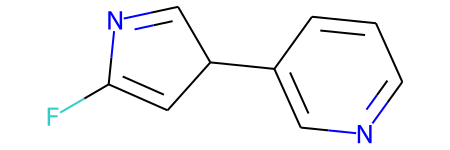

In [ ]:
to_mol('FC1=CC(c2cnccc2)C=N1')

Lets add mapping so we can refer to specific structures

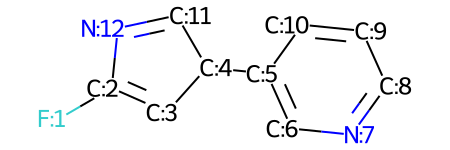

In [ ]:
to_mol(add_map_nums(to_mol('FC1=CC(c2cnccc2)C=N1')))

For this compound we want the following:

Experiment with adding N,O atoms at atoms 3, 11, 12

Experiment with adding N atoms at 5,6,8,10

Keep atom 7 N, keep atom 9 C

Experiment with removing carbon 10 or carbon 8 but not both

Experiment with F, Cl, Br, None Halogens at atom 1

Enumerate bond configurations in the 6 member ring but leave the 5 member ring as is

We also have the following constraints:

No more than 4 N,O heteroatoms (not counting halogens)

No `[N,O]-[N,O]` direct linkages

We proceed generating atom and bond spec templates

In [ ]:
mol = to_mol('FC1=CC(c2cnccc2)C=N1')

atom_spec, bond_spec, smarts = generate_spec_template(mol)
print(atom_spec)
print(bond_spec)
print(smarts)

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}
{(1, 2): [], (2, 3): [], (3, 4): [], (4, 5): [], (5, 6): [], (6, 7): [], (7, 8): [], (8, 9): [], (9, 10): [], (4, 11): [], (11, 12): [], (12, 2): [], (10, 5): []}
[#9:1]-[#6:2]1=[#6:3]-[#6:4](-[#6:5]2:[#6:6]:[#7:7]:[#6:8]:[#6:9]:[#6:10]:2)-[#6:11]=[#7:12]-1


And we fill in based on our above criteria

In [ ]:
atom_spec[1] = ['F', 'Cl', 'Br', -1]
atom_spec[3] = ['C','N', 'O']
atom_spec[5] = ['C','N']
atom_spec[6] = ['C','N']
atom_spec[8] = ['C','N', -1]
atom_spec[10] = ['C','N', -1]
atom_spec[11] = ['C','N','O']
atom_spec[12] = ['C','N','O']

bond_spec[(5,6)] = ['single', 'double', 'aromatic']
bond_spec[(6,7)] = ['single', 'double', 'aromatic']
bond_spec[(7,8)] = ['single', 'double', 'aromatic']
bond_spec[(8,9)] = ['single', 'double', 'aromatic']
bond_spec[(9,10)] = ['single', 'double', 'aromatic']
bond_spec[(10,5)] = ['single', 'double', 'aromatic']

In [ ]:
os.environ['ncpus'] = '0'

In [ ]:
enum = StructureEnumerator(smarts, atom_spec, bond_spec, max_num=20000000, 
                           substitute_bonds=['single', 'double', 'aromatic'])
enum.num_combos # possible combinations

2834352

In [ ]:
len(enum.combos) # after adjusting for removed atoms

6928416

Now we make a filter function to remove combinations based on our criteria of no more than 4 non-halogen heteroatoms and at most 1 atom removal

In [ ]:
def enum_filter(combo):
    n_o_count = 0.
    remove_count = 0.
    
    for k,v in combo.items():
        if (v=='O') or (v=='N'): # heteroatoms
            n_o_count += 1
            
        if v==-1:
            remove_count += 1
            
    output = True
    
    if n_o_count>4:
        output = False
    if remove_count>1:
        output = False
        
    return output

In [ ]:
enum.filter_combos(enum_filter)
len(enum.combos)

3067632

This leaves us with 3067632 combinations to enumerate

In [ ]:
smiles = enum.create_mols_chunks(500000)
len(smiles) # unique 

0
1
2
3
4
5
6


12561

Now we filter the outputs based on `check_ring_bonds` (removing SP atoms in rings) and our criteria for no `[N,O]-[N,O]` linkages and fewer than 5 N,O heteroatoms

In [ ]:
def check_linkage(smile):
    mol = to_mol(smile)
    pattern = Chem.MolFromSmarts('[#7,#8]~[#7,#8]')
    return not mol.HasSubstructMatch(pattern) 

def check_heteroatoms(smile):
    mol = to_mol(smile)
    count = 0.
    
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in ['N','O']:
            count += 1
            
    return count

In [ ]:
valid_smiles = []
for s in smiles:
    if check_ring_bonds(s) and check_heteroatoms(s)<5 and check_linkage(s):
        valid_smiles.append(s)

len(valid_smiles)

1592

From the enumeration we get 1592 structures, from an initial set of 3067632 possible combinations. This highlights the inefficiencies of structure enumeration. This technique is best left for expoiting highly constrained chemical spaces.

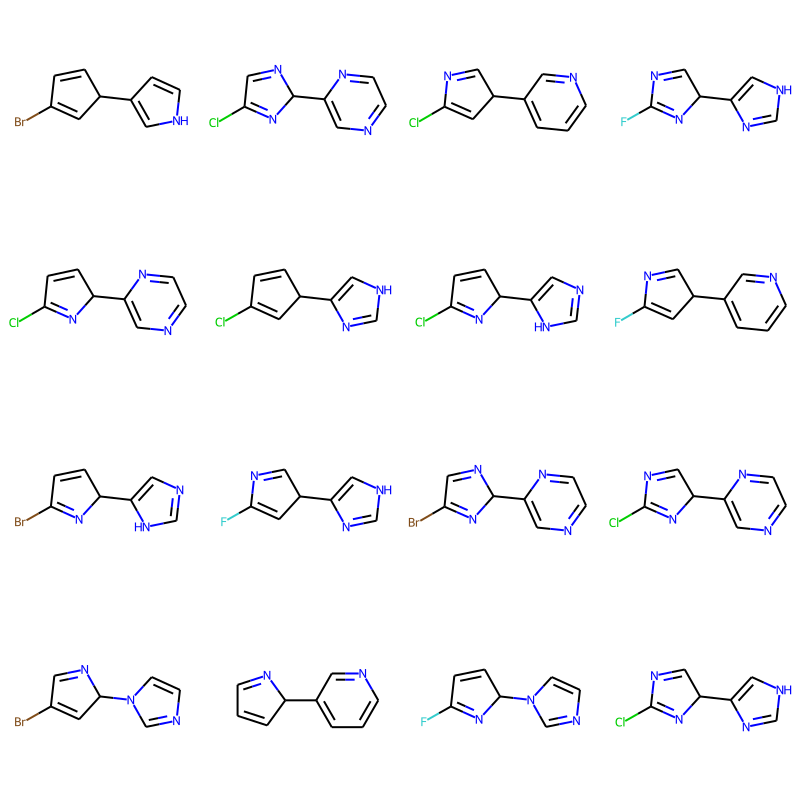

In [ ]:
subset = [i for i in valid_smiles if aromaticrings(to_mol(i))>0]

Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in np.random.choice(subset, 16)], molsPerRow=4)